In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

from crashpy.dataclasses import spectrum 
import scipy.constants as constants

In [ ]:
column_names=['x', 'y', 'z', 'a', 'Q', 'b', 'name', 'c',
'halo', 'd', 'packets', 'e', 'loc_uv', 'f', 'loc_x']
sources_path = '/ptmp/mpa/mglatzle/TNG_f_esc/e6/input/L/sn008/g111/sources_ic00.in'
sources = pd.read_table(sources_path, delimiter='\t', names=column_names)
sources['Q'] = sources['Q'].str.replace('d','e').astype('float')
sources_updated = sources[sources['Q']>0.01*sources['Q'].max()]
sources_updated['Q'] = sources_updated['Q'].astype(str)
sources_updated.to_csv(sources_path, sep='\t', header=False, index=False)

In [223]:
column_names=['x', 'y', 'z', 'a', 'Q', 'b', 'name', 'c',
'halo', 'd', 'packets', 'e', 'loc_uv', 'f', 'loc_x']
sources_path = '/ptmp/mpa/mglatzle/TNG_f_esc/merger_testing/input/L/sn008/g1029/sources_ic00.in'
sources = pd.read_table(sources_path, delimiter='\t', names=column_names)
#sources['Q'] = sources['Q'].str.replace('d','e').astype('float')
#sources['Q'] = sources['Q'].str.replace('d','e').astype('float')

In [193]:
lum_sources = sources[sources['Q']>0.01*sources['Q'].max()]
faint_sources = sources[sources['Q']<0.01*sources['Q'].max()]

In [3]:
def get_nearest_lum_source(faint_source, lum_sources):
    distances = []
    for _, source in lum_sources.iterrows():
        distance = np.sqrt((source.x-faint_source.x)**2+
                          (source.y-faint_source.y)**2+
                          (source.z-faint_source.z)**2)
        distances.append(distance)
    distances = np.array(distances)
    min_index = np.argmin(distances)
    min_value = distances[min_index]
    index = lum_sources.iloc[min_index].name
    return min_value, index

In [4]:
def source_merger(source_df, lum_source_idx, faint_source_idx, path_to_halo_spec):
    faint_source = source_df.loc[faint_source_idx]
    lum_source = source_df.loc[lum_source_idx]
    
    faint_spec_path = os.path.join(path_to_halo_spec, faint_source['name'][1:-1]+'.ps')
    lum_spec_path = os.path.join(path_to_halo_spec, lum_source['name'][1:-1]+'.ps')
    
    spec_faint = spectrum.CrashSpectrum.fromFile(faint_spec_path)
    spec_lum = spectrum.CrashSpectrum.fromFile(lum_spec_path)
    
    lum_faint = faint_source['Q']
    lum_lum = lum_source['Q']
    
    spec_faint.setEmissivity(lum_faint)
    spec_lum.setEmissivity(lum_lum)
    
    summed_spectrum = spectrum.CrashSpectrum(constants.e/constants.h*spec_lum.spectrum['hnu'], 
                                             spec_lum.spectrum['Lnu']+spec_faint.spectrum['Lnu'])
    
    out_path = lum_spec_path
    #out_path = os.path.join(path_to_halo_spec, f'test{lum_source_idx}.ps')
    summed_spectrum.toFile(path=out_path, f=True)
    
    source_df.loc[lum_source_idx, 'Q'] = lum_faint+lum_lum
    source_df.drop(faint_source_idx, inplace=True)
    return

In [5]:
def merge_halo_sources(path_to_input, path_to_spectra, snap, halo_id, threshold=0.01, max_dist=1.9):
    column_names=['x', 'y', 'z', 'a', 'Q', 'b', 'name', 'c',
    'halo', 'd', 'packets', 'e', 'loc_uv', 'f', 'loc_x']
    sources_path = os.path.join(path_to_input, snap, f'g{halo_id}','sources_ic00.in')
    spectra_path = os.path.join(path_to_spectra, snap, f'g{halo_id}')
    
    source_df = pd.read_table(sources_path, delimiter='\t', names=column_names)
    source_df['Q'] = source_df['Q'].str.replace('d','e').astype('float')
    
    lum_sources = source_df[source_df['Q']>threshold*source_df['Q'].max()]
    faint_sources = source_df[source_df['Q']<threshold*source_df['Q'].max()]
    for faint_idx, source in faint_sources.iterrows():
        dist, lum_source_idx = get_nearest_lum_source(faint_source=source, lum_sources=lum_sources)
        if dist > max_dist:
            source_df.drop(faint_idx, inplace=True)
        else:
            source_merger(source_df=source_df, lum_source_idx=lum_source_idx, 
                          faint_source_idx=faint_idx, 
                          path_to_halo_spec=spectra_path)
            
    source_df['Q'] = source_df['Q'].apply('{:.3e}'.format)
    source_df['Q'] = source_df['Q'].str.replace('e','d')
    source_df.to_csv(sources_path, sep='\t', header=False, index=False)
    return

In [6]:
def get_all_halos(path, snap):
    path_to_snap = os.path.join(path, snap)
    files = os.listdir(path_to_snap)
    halos = [int(halo[1:]) for halo in files if halo.startswith('g')]
    return halos

In [7]:
def all_halo_merge(path_to_input, path_to_spectra, threshold=0.01, max_dist=5):
    snaps = ['sn004','sn008','sn013']
    for snap in snaps:
        halos = get_all_halos(path_to_input, snap)
        for halo in halos:
            print(f'Merging sources in halo {halo} in snap {snap}')
            column_names=['x', 'y', 'z', 'a', 'Q', 'b', 'name', 'c',
            'halo', 'd', 'packets', 'e', 'loc_uv', 'f', 'loc_x']
            sources_path = os.path.join(path_to_input, snap, f'g{halo_id}','sources_ic00.in')
            spectra_path = os.path.join(path_to_spectra, snap, f'g{halo_id}')

            source_df = pd.read_table(sources_path, delimiter='\t', names=column_names)
            source_df['Q'] = source_df['Q'].str.replace('d','e').astype('float')

            lum_sources = source_df[source_df['Q']>threshold*source_df['Q'].max()]
            faint_sources = source_df[source_df['Q']<threshold*source_df['Q'].max()]
            for faint_idx, source in faint_sources.iterrows():
                dist, lum_source_idx = get_nearest_lum_source(faint_source=source, lum_sources=lum_sources)
                if dist > max_dist:
                    source_df.drop(faint_idx, inplace=True)
                else:
                    source_merger(source_df=source_df, lum_source_idx=lum_source_idx, 
                                  faint_source_idx=faint_idx, 
                                  path_to_halo_spec=spectra_path)

            source_df['Q'] = source_df['Q'].apply('{:.3e}'.format)
            source_df['Q'] = source_df['Q'].str.replace('e','d')
            source_df.to_csv(sources_path, sep='\t', header=False, index=False)
    return

In [8]:
def get_threshold_lum(path_to_input, sample=100):
    all_lum = []
    snaps = ['sn004','sn008','sn013']
    for snap in snaps:
        halos = get_all_halos(path_to_input, snap)
        for halo in halos:
            column_names=['x', 'y', 'z', 'a', 'Q', 'b', 'name', 'c',
            'halo', 'd', 'packets', 'e', 'loc_uv', 'f', 'loc_x']
            sources_path = os.path.join(path_to_input, snap, f'g{halo}','sources_ic00.in')

            source_df = pd.read_table(sources_path, delimiter='\t', names=column_names)
            source_df['Q'] = source_df['Q'].str.replace('d','e').astype('float')
            source_df['lum'] = source_df['Q']
            all_lum.extend(np.array(source_df['lum']))
    all_lum = np.sort(all_lum)
    return np.average(all_lum[-sample:])

In [9]:
def source_merger_simple(source_df, lum_source_idx, faint_source_idx):
    faint_source = source_df.loc[faint_source_idx]
    lum_source = source_df.loc[lum_source_idx]
    
    lum_faint = faint_source['Q']
    lum_lum = lum_source['Q']
    
    source_df.loc[lum_source_idx,'Q'] = lum_faint+lum_lum
    source_df.drop(faint_source_idx, inplace=True)
    return

In [10]:
def all_halo_merge_simple(path_to_input, lum_threshold=False, threshold=0.01, max_dist=5, sample=100):
    if lum_threshold:
        threshold_lum = get_threshold_lum(path_to_input, sample=sample)
    snaps = ['sn004','sn008','sn013']
    for snap in snaps:
        print(snap)
        halos = get_all_halos(path_to_input, snap)
        for halo in halos:
            #print(f'Merging sources in halo {halo} in snap {snap}')
            column_names=['x', 'y', 'z', 'a', 'Q', 'b', 'name', 'c',
            'halo', 'd', 'packets', 'e', 'loc_uv', 'f', 'loc_x']
            sources_path = os.path.join(path_to_input, snap, f'g{halo}','sources_ic00.in')

            source_df = pd.read_table(sources_path, delimiter='\t', names=column_names)
            source_df['Q'] = source_df['Q'].str.replace('d','e').astype('float')
            
            if lum_threshold:
                lum_sources = source_df[source_df['Q']>threshold*threshold_lum]
                faint_sources = source_df[source_df['Q']<threshold*threshold_lum]
            else:
                lum_sources = source_df[source_df['Q']>threshold*source_df['Q'].max()]
                faint_sources = source_df[source_df['Q']<threshold*source_df['Q'].max()]
                
            for faint_idx, source in faint_sources.iterrows():
                if len(lum_sources) != 0:
                    dist, lum_source_idx = get_nearest_lum_source(faint_source=source, lum_sources=lum_sources)
                    if dist > max_dist:
                        source_df.drop(faint_idx, inplace=True)
                    else:
                        source_merger_simple(source_df=source_df, lum_source_idx=lum_source_idx, 
                                      faint_source_idx=faint_idx)
                else:
                    source_df.drop(faint_idx, inplace=True)
                    
            if len(lum_sources) == 0:
                print(f'Halo {halo} in snap {snap} has no luminous sources')
                source_df.to_csv(sources_path, sep='\t', header=False, index=False)
            else:      
                source_df['Q'] = source_df['Q'].apply('{:.3e}'.format)
                source_df['Q'] = source_df['Q'].str.replace('e','d')
                source_df.to_csv(sources_path, sep='\t', header=False, index=False)
    return

In [90]:
path_to_1e4_rad5 = '/ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/rad_5/input_1e-4/L35n2160TNG'
all_halo_merge_simple(path_to_1e4_rad5, lum_threshold=False, threshold=1e-4, max_dist=5, sample=100)

Merging sources in halo 7348 in snap sn004
Merging sources in halo 6053 in snap sn004
Merging sources in halo 758 in snap sn004
Merging sources in halo 218 in snap sn004
Merging sources in halo 825 in snap sn004
Merging sources in halo 872 in snap sn004
Merging sources in halo 2048 in snap sn004
Merging sources in halo 214 in snap sn004
Merging sources in halo 3995 in snap sn004
Merging sources in halo 2184 in snap sn004
Merging sources in halo 2302 in snap sn004
Merging sources in halo 71 in snap sn004
Merging sources in halo 663 in snap sn004
Merging sources in halo 611 in snap sn004
Merging sources in halo 3854 in snap sn004
Merging sources in halo 1415 in snap sn004
Merging sources in halo 361 in snap sn004
Merging sources in halo 4276 in snap sn004
Merging sources in halo 4679 in snap sn008
Merging sources in halo 2634 in snap sn008
Merging sources in halo 5604 in snap sn008
Merging sources in halo 791 in snap sn008
Merging sources in halo 386 in snap sn008
Merging sources in halo

In [91]:
path_to_5e4_rad5 = '/ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/rad_5/input_5e-4/L35n2160TNG'
all_halo_merge_simple(path_to_5e4_rad5, lum_threshold=False, threshold=5e-4, max_dist=5, sample=100)

path_to_1e3_rad5 = '/ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/rad_5/input_1e-3/L35n2160TNG'
all_halo_merge_simple(path_to_1e3_rad5, lum_threshold=False, threshold=1e-3, max_dist=5, sample=100)

path_to_5e3_rad5 = '/ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/rad_5/input_5e-3/L35n2160TNG'
all_halo_merge_simple(path_to_5e3_rad5, lum_threshold=False, threshold=5e-3, max_dist=5, sample=100)

path_to_1e2_rad5 = '/ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/rad_5/input_1e-2/L35n2160TNG'
all_halo_merge_simple(path_to_1e2_rad5, lum_threshold=False, threshold=1e-2, max_dist=5, sample=100)

path_to_5e2_rad5 = '/ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/rad_5/input_5e-2/L35n2160TNG'
all_halo_merge_simple(path_to_5e2_rad5, lum_threshold=False, threshold=5e-2, max_dist=5, sample=100)

Merging sources in halo 7348 in snap sn004
Merging sources in halo 6053 in snap sn004
Merging sources in halo 758 in snap sn004
Merging sources in halo 218 in snap sn004
Merging sources in halo 825 in snap sn004
Merging sources in halo 872 in snap sn004
Merging sources in halo 2048 in snap sn004
Merging sources in halo 214 in snap sn004
Merging sources in halo 3995 in snap sn004
Merging sources in halo 2184 in snap sn004
Merging sources in halo 2302 in snap sn004
Merging sources in halo 71 in snap sn004
Merging sources in halo 663 in snap sn004
Merging sources in halo 611 in snap sn004
Merging sources in halo 3854 in snap sn004
Merging sources in halo 1415 in snap sn004
Merging sources in halo 361 in snap sn004
Merging sources in halo 4276 in snap sn004
Merging sources in halo 4679 in snap sn008
Merging sources in halo 2634 in snap sn008
Merging sources in halo 5604 in snap sn008
Merging sources in halo 791 in snap sn008
Merging sources in halo 386 in snap sn008
Merging sources in halo

Merging sources in halo 19512 in snap sn013
Merging sources in halo 1992 in snap sn013
Merging sources in halo 62846 in snap sn013
Merging sources in halo 8727 in snap sn013
Merging sources in halo 21424 in snap sn013
Merging sources in halo 2498 in snap sn013
Merging sources in halo 17206 in snap sn013
Merging sources in halo 40553 in snap sn013
Merging sources in halo 3361 in snap sn013
Merging sources in halo 7348 in snap sn004
Merging sources in halo 6053 in snap sn004
Merging sources in halo 758 in snap sn004
Merging sources in halo 218 in snap sn004
Merging sources in halo 825 in snap sn004
Merging sources in halo 872 in snap sn004
Merging sources in halo 2048 in snap sn004
Merging sources in halo 214 in snap sn004
Merging sources in halo 3995 in snap sn004
Merging sources in halo 2184 in snap sn004
Merging sources in halo 2302 in snap sn004
Merging sources in halo 71 in snap sn004
Merging sources in halo 663 in snap sn004
Merging sources in halo 611 in snap sn004
Merging sources

Merging sources in halo 20915 in snap sn013
Merging sources in halo 1176 in snap sn013
Merging sources in halo 2044 in snap sn013
Merging sources in halo 1278 in snap sn013
Merging sources in halo 723 in snap sn013
Merging sources in halo 665 in snap sn013
Merging sources in halo 34017 in snap sn013
Merging sources in halo 3090 in snap sn013
Merging sources in halo 19512 in snap sn013
Merging sources in halo 1992 in snap sn013
Merging sources in halo 62846 in snap sn013
Merging sources in halo 8727 in snap sn013
Merging sources in halo 21424 in snap sn013
Merging sources in halo 2498 in snap sn013
Merging sources in halo 17206 in snap sn013
Merging sources in halo 40553 in snap sn013
Merging sources in halo 3361 in snap sn013
Merging sources in halo 7348 in snap sn004
Merging sources in halo 6053 in snap sn004
Merging sources in halo 758 in snap sn004
Merging sources in halo 218 in snap sn004
Merging sources in halo 825 in snap sn004
Merging sources in halo 872 in snap sn004
Merging so

In [96]:
path_to_1e4_rad5 = '/ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/rad_10/input_1e-4/L35n2160TNG'
all_halo_merge_simple(path_to_1e4_rad5, lum_threshold=False, threshold=1e-4, max_dist=10, sample=100)

path_to_5e4_rad5 = '/ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/rad_10/input_5e-4/L35n2160TNG'
all_halo_merge_simple(path_to_5e4_rad5, lum_threshold=False, threshold=5e-4, max_dist=10, sample=100)

path_to_1e3_rad5 = '/ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/rad_10/input_1e-3/L35n2160TNG'
all_halo_merge_simple(path_to_1e3_rad5, lum_threshold=False, threshold=1e-3, max_dist=10, sample=100)

path_to_5e3_rad5 = '/ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/rad_10/input_5e-3/L35n2160TNG'
all_halo_merge_simple(path_to_5e3_rad5, lum_threshold=False, threshold=5e-3, max_dist=10, sample=100)

path_to_1e2_rad5 = '/ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/rad_10/input_1e-2/L35n2160TNG'
all_halo_merge_simple(path_to_1e2_rad5, lum_threshold=False, threshold=1e-2, max_dist=10, sample=100)

path_to_5e2_rad5 = '/ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/rad_10/input_5e-2/L35n2160TNG'
all_halo_merge_simple(path_to_5e2_rad5, lum_threshold=False, threshold=5e-2, max_dist=10, sample=100)

sn004


UnboundLocalError: local variable 'threshold_lum' referenced before assignment

In [ ]:
path_to_1e3_rad5 = '/ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/global_cutoff/input_1e-3/L35n2160TNG'
all_halo_merge_simple(path_to_1e3_rad5, lum_threshold=True, threshold=1e-3, max_dist=5, sample=100)

In [102]:
# path_to_1e4_rad5 = '/ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/global_cutoff/input_1e-4/L35n2160TNG'
# all_halo_merge_simple(path_to_1e4_rad5, lum_threshold=True, threshold=1e-4, max_dist=5, sample=100)

# path_to_5e4_rad5 = '/ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/global_cutoff/input_5e-4/L35n2160TNG'
# all_halo_merge_simple(path_to_5e4_rad5, lum_threshold=True, threshold=5e-4, max_dist=5, sample=100)

path_to_1e3_rad5 = '/ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/global_cutoff/input_1e-3/L35n2160TNG'
all_halo_merge_simple(path_to_1e3_rad5, lum_threshold=True, threshold=1e-3, max_dist=5, sample=100)

path_to_5e3_rad5 = '/ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/global_cutoff/input_5e-3/L35n2160TNG'
all_halo_merge_simple(path_to_5e3_rad5, lum_threshold=True, threshold=5e-3, max_dist=5, sample=100)

path_to_1e2_rad5 = '/ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/global_cutoff/input_1e-2/L35n2160TNG'
all_halo_merge_simple(path_to_1e2_rad5, lum_threshold=True, threshold=1e-2, max_dist=5, sample=100)

path_to_5e2_rad5 = '/ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/global_cutoff/input_5e-2/L35n2160TNG'
all_halo_merge_simple(path_to_5e2_rad5, lum_threshold=True, threshold=5e-2, max_dist=5, sample=100)

1.2925300000000002
sn004
0.0012925300000000003
sn008
0.0012925300000000003
Halo 3837 in snap sn008 has no luminous sources
Halo 3837 in snap sn008 has no luminous sources
Halo 12909 in snap sn008 has no luminous sources
Halo 12909 in snap sn008 has no luminous sources
sn013
0.0012925300000000003
Halo 61869 in snap sn013 has no luminous sources
Halo 61869 in snap sn013 has no luminous sources
1.2925300000000002
sn004
0.006462650000000001
Halo 7348 in snap sn004 has no luminous sources
Halo 7348 in snap sn004 has no luminous sources
Halo 2048 in snap sn004 has no luminous sources
Halo 2048 in snap sn004 has no luminous sources
Halo 3995 in snap sn004 has no luminous sources
Halo 3995 in snap sn004 has no luminous sources
sn008
0.006462650000000001
Halo 3837 in snap sn008 has no luminous sources
Halo 3837 in snap sn008 has no luminous sources
Halo 12909 in snap sn008 has no luminous sources
Halo 12909 in snap sn008 has no luminous sources
sn013
0.006462650000000001
Halo 4238 in snap sn013

In [26]:
path = '/ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis'
path_all_sources = '/ptmp/mpa/mglatzle/TNG_f_esc/all_sources/input/L35n2160TNG'
for subdir in os.listdir(path):
    subdir_path = os.path.join(path, subdir)
    for subsubdir in os.listdir(subdir_path):
        subsubdir_path = os.path.join(subdir_path, subsubdir)
        indir_path = os.path.join(subsubdir_path, 'L35n2160TNG')
        print(f'Deleting content of {subsubdir_path}')
        #os.system(f'rm -r {indir_path}')
        os.system(f'cp -r {path_all_sources} {subsubdir_path}')

Deleting content of /ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/rad_10/input_5e-2


0

Deleting content of /ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/rad_10/input_1e-4


0

Deleting content of /ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/rad_10/input_5e-3


0

Deleting content of /ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/rad_10/input_5e-4


0

Deleting content of /ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/rad_10/input_1e-3


0

Deleting content of /ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/rad_10/input_1e-2


0

Deleting content of /ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/rad_10/input_all


0

Deleting content of /ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/rad_5/input_5e-2


0

Deleting content of /ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/rad_5/input_1e-4


0

Deleting content of /ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/rad_5/input_5e-3


0

Deleting content of /ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/rad_5/input_5e-4


0

Deleting content of /ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/rad_5/input_1e-3


0

Deleting content of /ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/rad_5/input_1e-2


0

Deleting content of /ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/rad_5/input_all


0

Deleting content of /ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/global_cutoff/input_5e-2


0

Deleting content of /ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/global_cutoff/input_1e-4


0

Deleting content of /ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/global_cutoff/input_5e-3


0

Deleting content of /ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/global_cutoff/input_5e-4


0

Deleting content of /ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/global_cutoff/input_1e-3


0

Deleting content of /ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/global_cutoff/input_1e-2


0

Deleting content of /ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis/global_cutoff/input_all


0

In [11]:
def all_halo_global_threshold(path_to_input, path_to_spectra, threshold=0.01, max_dist=1.9):
    
    snaps = ['sn004','sn008','sn013']
    for snap in snaps:
        halos = get_all_halos(path_to_input, snap)
        for halo in halos:
            print(f'Merging sources in halo {halo} in snap {snap}')
            merge_halo_sources(path_to_input=path_to_input, path_to_spectra=path_to_spectra, snap=snap, 
                               halo_id=halo, threshold=threshold, max_dist=max_dist)
    return

In [514]:
path_to_input = '/ptmp/mpa/mglatzle/TNG_f_esc/quick_test/input/L35n2160TNG'
path_to_spectra = '/ptmp/mpa/mglatzle/TNG_f_esc/quick_test/db/SPECTRA/L35n2160TNG'
merge_halo_sources(path_to_input, path_to_spectra, snap, halo_id=1029, threshold=0.01, max_dist=5)

In [326]:
path_to_input = '/ptmp/mpa/mglatzle/TNG_f_esc/source_conv/input/L35n2160TNG'
path_to_spectra = '/ptmp/mpa/mglatzle/TNG_f_esc/source_conv/db/SPECTRA/L35n2160TNG'
snap='sn008'
merge_halo_sources(path_to_input, path_to_spectra, snap, halo_id=1, threshold=0.001, max_dist=1.9)
merge_halo_sources(path_to_input, path_to_spectra, snap, halo_id=100, threshold=0.005, max_dist=1.9)
merge_halo_sources(path_to_input, path_to_spectra, snap, halo_id=111, threshold=0.01, max_dist=1.9)
merge_halo_sources(path_to_input, path_to_spectra, snap, halo_id=1029, threshold=0.05, max_dist=1.9)

In [329]:
path_to_input = '/ptmp/mpa/mglatzle/TNG_f_esc/mer8_cor/input/L35n2160TNG'
path_to_spectra = '/ptmp/mpa/mglatzle/TNG_f_esc/mer8_cor/db/SPECTRA/L35n2160TNG'
snap='sn008'
merge_halo_sources(path_to_input, path_to_spectra, snap, halo_id=1, threshold=0.01, max_dist=0.5)
merge_halo_sources(path_to_input, path_to_spectra, snap, halo_id=100, threshold=0.01, max_dist=1.9)
merge_halo_sources(path_to_input, path_to_spectra, snap, halo_id=111, threshold=0.01, max_dist=5)
merge_halo_sources(path_to_input, path_to_spectra, snap, halo_id=1029, threshold=0.01, max_dist=10)

In [324]:
path_to_input = '/ptmp/mpa/mglatzle/TNG_f_esc/conv1e9/input/L35n2160TNG'
path_to_spectra = '/ptmp/mpa/mglatzle/TNG_f_esc/conv1e9/db/SPECTRA/L35n2160TNG'
all_halo_merge(path_to_input, path_to_spectra, threshold=0.01, max_dist=1.9)

Merging sources in halo 7348 in snap sn004
Merging sources in halo 6053 in snap sn004
Merging sources in halo 758 in snap sn004
Merging sources in halo 218 in snap sn004
Merging sources in halo 825 in snap sn004
Merging sources in halo 872 in snap sn004
Merging sources in halo 2048 in snap sn004
Merging sources in halo 214 in snap sn004
Merging sources in halo 3995 in snap sn004
Merging sources in halo 2184 in snap sn004
Merging sources in halo 2302 in snap sn004
Merging sources in halo 71 in snap sn004
Merging sources in halo 663 in snap sn004
Merging sources in halo 611 in snap sn004
Merging sources in halo 3854 in snap sn004
Merging sources in halo 1415 in snap sn004
Merging sources in halo 361 in snap sn004
Merging sources in halo 4276 in snap sn004
Merging sources in halo 4679 in snap sn008
Merging sources in halo 2634 in snap sn008
Merging sources in halo 5604 in snap sn008
Merging sources in halo 791 in snap sn008
Merging sources in halo 386 in snap sn008
Merging sources in halo

In [307]:
path_to_input = '/ptmp/mpa/mglatzle/TNG_f_esc/merger8/input/L'
path_to_spectra = '/ptmp/mpa/mglatzle/TNG_f_esc/merger8/db/SPECTRA/L35n2160TNG'
snap = 'sn008'
halo_id = 1029
merge_halo_sources(path_to_input, path_to_spectra, snap, halo_id, threshold=0.01, max_dist=5.3)

In [12]:
def get_job_list(jobnum=200):
    jobs = ''
    folder_name = os.getcwd().split('/')[-1]
    job_name = f'run-{folder_name}-chunk'
    for i in range(jobnum):
        jobs += f'{job_name}{i},'
    return jobs

In [13]:
from crashpy.utilities import crashMemMap
from pyphfit2 import phfit2
from crashpy.dataclasses.simulation import LoadedSimulation as Sim
from crashpy.dataclasses.spectrum import CrashSpectrum as Spec
import scipy.constants as const
import astropy.units as u

In [14]:
def get_cell_size_cm(ic):
    cell_size = (ic.getCellSize()[1]*u.Mpc).to(u.cm).value
    return cell_size

In [15]:
def get_simulation_path(halo_id, redshift, conf):
    halo_path = get_sim_path(halo_id=halo_id, redshift=redshift, conf=conf)
    path_out =  os.path.join(halo_path, 'Output/phys_ic00_rt05.out')
    #path_out =  '/ptmp/mpa/mglatzle/TNG_f_esc/524_1029/run/L35n2160TNG/sn00phys_ic00_rt05.out'
    #path_dens = os.path.join(halo_path, 'Input/dens_ic00.in')
    return path_out#, path_dens
def get_temperature_path(halo_id, redshift, conf):
    halo_path = get_sim_path(halo_id=halo_id, redshift=redshift, conf=conf)
    path_in =  os.path.join(halo_path, 'Input/temp_ic00.in')
    #path_out =  '/ptmp/mpa/mglatzle/TNG_f_esc/524_1029/run/L35n2160TNG/sn00phys_ic00_rt05.out'
    #path_dens = os.path.join(halo_path, 'Input/dens_ic00.in')
    return path_in#, path_dens

def get_H_map(halo):
    return np.ones(halo[1].shape)-halo[1]

def get_He_map(halo):
    return np.ones(halo[1].shape)-halo[2]-halo[3]

In [16]:
def get_snap_num(redshift):
    redshift_dic = {6:'sn013',8:'sn008',10:'sn004'}
    return redshift_dic[redshift]

In [17]:
def get_sim_path(halo_id, redshift, conf):
    snap = get_snap_num(redshift)
    return f'/freya/ptmp/mpa/mglatzle/TNG_f_esc/{conf}/run/L35n2160TNG/{snap}/g{halo_id}'

In [18]:
def get_sim(halo_id, redshift, conf):
    simpath = get_sim_path(halo_id, redshift, conf)
    print(simpath)
    return Sim(simpath)

In [19]:
def get_density_maps(halo_id, redshift, conf, ic_num='00'):
    path_out = get_simulation_path(halo_id=halo_id, redshift=redshift, conf=conf)
    temperature_path = get_temperature_path(halo_id=halo_id, redshift=redshift, conf=conf)
    sim = get_sim(halo_id, redshift, conf)
    ic = sim.ICs[ic_num]
    #halo = crashMemMap(path_out, 'all')
    temp = crashMemMap(temperature_path)
    density_maps = {}
    density_maps['H'] = ic.getHDensity()
#     density_maps['HI'] = get_H_map(halo)*ic.getHDensity()
#     density_maps['HeI'] = get_He_map(halo)*ic.getHeDensity()
#     density_maps['HeII'] = halo[2]*ic.getHeDensity()
    density_maps['T'] = temp
    
    cell_size_cm = get_cell_size_cm(ic)
    return cell_size_cm, density_maps

In [20]:
def stroemgren_rad(density, temperature, luminosity):
    beta =2e-10*temperature**(-3/4)
    radius = (3/(4*np.pi)*luminosity/(density**2*beta))**(1/3)
    return radius

In [21]:
def average_quantities(source_pos, radius, densities, temperatures):
    inner_densities = []
    inner_temp = []
    max_rad = int(radius)
    for i in range(2*max_rad+1):
        for j in range(2*max_rad+1):
            for k in range(2*max_rad+1):
                x_dist = -max_rad+i
                y_dist = -max_rad+j
                z_dist = -max_rad+k
                dist = np.sqrt(x_dist**2+y_dist**2+z_dist**2)
                if dist<radius:
                    try:
                        inner_densities.append(densities[source_pos[0]+int(x_dist), source_pos[1]+int(y_dist), source_pos[2]+int(z_dist)])
                        inner_temp.append(temperatures[source_pos[0]+int(x_dist), source_pos[1]+int(y_dist), source_pos[2]+int(z_dist)])
                    except:
                        #print(source_pos[0]+int(x_dist), source_pos[1]+int(y_dist), source_pos[2]+int(z_dist))
                        pass
    T_average = np.sum(np.array(inner_densities)*np.array(inner_temp))/np.sum(np.array(inner_densities))
    return np.average(np.array(inner_densities)), T_average

In [99]:
cell_size, density_maps = get_density_maps(1029, 8, 'all_sources')

/freya/ptmp/mpa/mglatzle/TNG_f_esc/all_sources/run/L35n2160TNG/sn008/g1029


In [100]:
cell_size

3.788209002822238e+20

In [478]:
density_maps['H'].shape

(93, 93, 93)

In [481]:
coord[0].shape

(3,)

In [22]:
def get_distances(coordinates, radius):
    distances = []
    for coordinate in coordinates:
        x_dist = coordinate[0]-radius
        y_dist = coordinate[1]-radius
        z_dist = coordinate[2]-radius
        dist = np.sqrt(x_dist**2+y_dist**2+z_dist**2)/radius
        distances.append(dist)
    return np.array(distances)

In [520]:
distances = get_distances(coord, 93/2)

In [503]:
len(distances)

61

In [23]:
def all_stroemgren_rad(config):
    column_names=['x', 'y', 'z', 'a', 'Q', 'b', 'name', 'c', 'halo', 'd', 'packets', 'e', 'loc_uv', 'f', 'loc_x']
    base_path = '/ptmp/mpa/mglatzle/TNG_f_esc'
    input_path = 'input/L35n2160TNG'
    run_path = 'run/L35n2160TNG'
    config_path = os.path.join(base_path, config)
    input_path = os.path.join(config_path, input_path)
    run_path = os.path.join(config_path, run_path)
    snaps = ['sn004', 'sn008', 'sn013']
    radius = 5.
    
    stroemgren = []
    luminosities = []
    for snap in snaps:
        snap_path = os.path.join(input_path, snap)
        run_snap_path = os.path.join(run_path, snap)
        for halo in os.listdir(snap_path):
            if halo.startswith('g'):
                
                halo_path = os.path.join(snap_path, halo)
                halo_run_path = os.path.join(run_snap_path, halo)
                source_name = 'sources_ic00.in'
                dens_name = 'dens_ic00.in'
                sources_path = os.path.join(halo_path, source_name)
                dens_path = os.path.join(halo_path, dens_name)
                sources = pd.read_table(sources_path, delimiter='\t', names=column_names)
                initial_lum = sources['Q'].str.replace('d','e').astype('float')
                
                try:
                    sim = Sim(halo_run_path)
                except:
                    print(halo_run_path)
                    continue

                coordinates = np.array([sources.x, sources.y, sources.z])
                coord = coordinates.T
                lum = np.array(initial_lum) 
                luminosities.extend(lum)
            
                ic = sim.ICs['00']
                halo_maps = crashMemMap(dens_path, 'all')
                density_maps = {}
                density_maps['H'] = ic.getHDensity()
                density_maps['T'] = halo_maps[0]
                cell_size_cm = get_cell_size_cm(ic)
                
                for i in range(len(lum)):
                    densities = density_maps['H']
                    temperature = density_maps['T']
                    source_pos = coord[i]
                    luminosity=lum[i]*1e52
                    density, temperature = average_quantities(source_pos, radius, densities, temperature)
                    stroem_rad = stroemgren_rad(density, temperature, luminosity)/cell_size_cm
                    stroemgren.append(stroem_rad)
    return luminosities, stroemgren

In [4]:
df_merge = pd.read_pickle('dfs/merge_escape_source.pickle')

In [24]:
def z_to_snap(z):
    z_dict = {6:'sn013', 8:'sn008', 10:'sn004'}
    return z_dict[z]

In [25]:
def source_dist(ID, redshift, conf, side_length):
    snap = z_to_snap(redshift)
    path_sources = f'/ptmp/mpa/mglatzle/TNG_f_esc/{conf}/run/L35n2160TNG/{snap}/g{ID}/Input/sources_ic00.in'
    
    # 0.5 is needed to take into account that the sources are at the center of the grid voxel, move origin to halo center
    coord = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[0,1,2])+0.5-side_length/2
    rel_dist = np.sqrt(np.sum(coord**2, axis=1))*2/side_length
    
    return rel_dist

In [26]:
def add_dist(df, conf):
    distances = []
    stroemgren_rads = []
    column_names=['x', 'y', 'z', 'a', 'Q', 'b', 'name', 'c', 'halo', 'd', 'packets', 'e', 'loc_uv', 'f', 'loc_x']
    for index, row in df.iterrows():
        
        snap = z_to_snap(row.z)
        
        halo_path = f'/ptmp/mpa/mglatzle/TNG_f_esc/{conf}/input/L35n2160TNG/{snap}/g{row.ID}'
        halo_run_path = f'/ptmp/mpa/mglatzle/TNG_f_esc/{conf}/run/L35n2160TNG/{snap}/g{row.ID}'
        source_name = 'sources_ic00.in'
        dens_name = 'dens_ic00.in'
        temp_name = 'temp_ic00.in'
        sources_path = os.path.join(halo_path, source_name)
        dens_path = os.path.join(halo_path, dens_name)
        temp_path = os.path.join(halo_path, temp_name)
        sources = pd.read_table(sources_path, delimiter='\t', names=column_names)
        
        coordinates = np.array([sources.x, sources.y, sources.z])
        coord = coordinates.T
        
        dist = source_dist(row.ID, row.z, conf, row.GridSize)
        distances.append(dist)
        try:
            sim = Sim(halo_run_path)
        except:
            print(halo_run_path)
            #continue
        ic = sim.ICs['00']
        #halo_maps = crashMemMap(dens_path, 'all')
        density_maps = {}
        density_maps['H'] = ic.getHDensity()
        density_maps['T'] = crashMemMap(temp_path)
        cell_size_cm = get_cell_size_cm(ic)
        initial_lum = sources['Q'].str.replace('d','e').astype('float')
        lum = np.array(initial_lum) 
        density_map = density_maps['H']
        temperature_map = density_maps['T']
        cell_size_cm = get_cell_size_cm(ic)
        stroemgren = []
        for i in range(len(lum)):
            source_pos = coord[i]
            luminosity=lum[i]*1e52
            density, temperature = average_quantities(source_pos, 5, density_map, temperature_map)
            stroem_rad = stroemgren_rad(density, temperature, luminosity)/cell_size_cm
            stroemgren.append(stroem_rad)
        stroemgren_rads.append(stroemgren)
    df['Distances'] = pd.Series(distances)
    df['Stroemgren'] = pd.Series(stroemgren_rads)
    return

In [151]:
add_dist(df_merge, 'all_sources')

In [262]:
for i, element in df_merge.iloc[[13, 18, 25]].iterrows():
    element.GridSize
    element.ID
    element.z
    print('-'*85)

35

40553

6

-------------------------------------------------------------------------------------


29

17656

8

-------------------------------------------------------------------------------------


20

6053

10

-------------------------------------------------------------------------------------


In [27]:
def get_all_halos(path, snap):
    path_to_snap = os.path.join(path, snap)
    files = os.listdir(path_to_snap)
    halos = [int(halo[1:]) for halo in files if halo.startswith('g')]
    return halos

In [42]:
def get_time_estimation(path_to_input):
    snaps = ['sn004','sn008','sn013']
    df_name = 'sel_halos_df.pickle'
    times = []
    star_masses = []
    for snap in snaps:
        halos = get_all_halos(path_to_input, snap)
        df_path = os.path.join(path_to_input, snap, df_name)
        all_halos = pd.read_pickle(df_path)
        halos_used = all_halos.loc[halos]
        for halo in halos:
            star_mass = halos_used.loc[halo][('GroupMassType', 4)]*1e10/0.6774
            grid_size = halos_used.loc[halo][('shape', 0)]
            column_names=['x', 'y', 'z', 'a', 'Q', 'b', 'name', 'c',
            'halo', 'd', 'packets', 'e', 'loc_uv', 'f', 'loc_x']
            sources_path = os.path.join(path_to_input, snap, f'g{halo}','sources_ic00.in')
            try:
                source_df = pd.read_table(sources_path, delimiter='\t', names=column_names)
            except:
                print(f'Halo {halo} in snap {snap} does not seem to have a sources file!')
            source_df['Q'] = source_df['Q'].str.replace('d','e').astype('float')
            time_est = len(source_df['Q'])*245.75*grid_size
            times.append(time_est)
            star_masses.append(star_mass)
    return star_masses, times

In [31]:
star_masses, times = get_time_estimation('/ptmp/mpa/mglatzle/TNG_f_esc/conv1e8/input/L35n2160TNG')

In [45]:
import scipy.stats as stat
import matplotlib

In [33]:
slope, intercept, r, p, se = stat.linregress(np.log10(star_masses),np.log10(np.array(times)/3600/24))

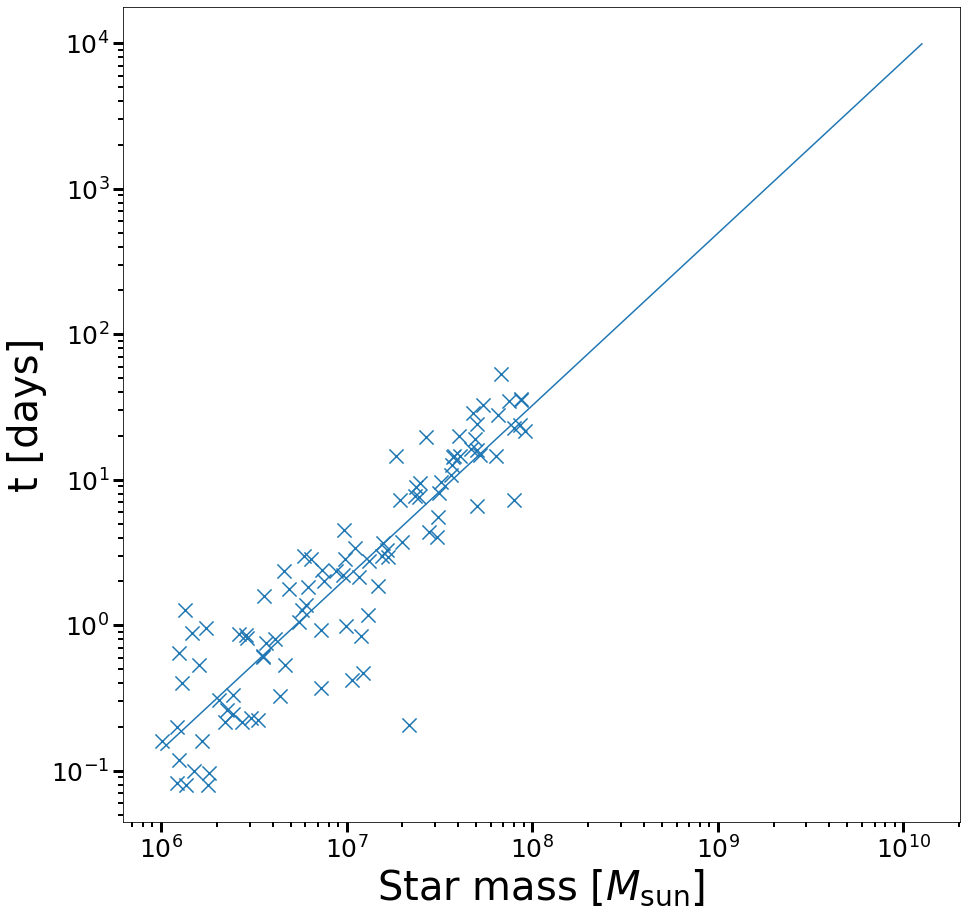

In [48]:
x_values = np.linspace(6, 10.1, 100)
plt.plot(10**x_values, 10**(x_values*slope+intercept))
plt.scatter(star_masses,np.array(times)/3600/24, marker='x', s=200)
#plt.scatter(np.log10(star_masses),np.log10(np.array(times)/3600/24), marker='x', s=200)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Star mass $[M_\mathrm{sun}]$', size=40)
plt.ylabel(r't [days]', size=40)
plt.tick_params(length=10, width=3)
plt.tick_params(length=5, width=2, which='minor')
matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25) 
plt.rcParams["figure.figsize"] = (15,15);

In [269]:
halos = get_all_halos('/ptmp/mpa/mglatzle/TNG_f_esc/conv1e8/input/L35n2160TNG','sn013')
df_path = '/ptmp/mpa/mglatzle/TNG_f_esc/conv1e8/input/L35n2160TNG/sn013/sel_halos_df.pickle'
all_halos = pd.read_pickle(df_path)
halos_used = all_halos.loc[halos]

In [235]:
def get_quantities(df):
    mean_distance = []
    mean_distance_lum = []
    mean_ages = []
    far_luminosities = []
    mean_stroemgren = []
    for index, row in df.iterrows():
        mean_dist = row.Distances.mean()
        mean_dist_lum = np.sum(row.Distances*row.Luminosities)/np.sum(row.Luminosities)
        mean_age = row.StellarAges.mean()
        
        mean_distance.append(mean_dist)
        mean_distance_lum.append(mean_dist_lum)
        mean_ages.append(mean_age)
        stroemgren = []
        far_lum = 0
        for i in range(len(row.Distances)):
            if row.Distances[i]>0.25:
                far_lum += row.Luminosities[i]
                stroemgren.append(row.Stroemgren[i])
        far_luminosities.append(far_lum/row.Luminosities.sum())
        mean_stroemgren.append(np.mean(stroemgren))
    df['MeanDistances'] = pd.Series(mean_distance)
    df['MeanDistanceLum'] = pd.Series(mean_distance_lum)
    df['MeanAges'] = pd.Series(mean_ages)
    df['FarLum'] = pd.Series(far_luminosities)
    df['FarMeanStroemgren'] = pd.Series(mean_stroemgren)
    return

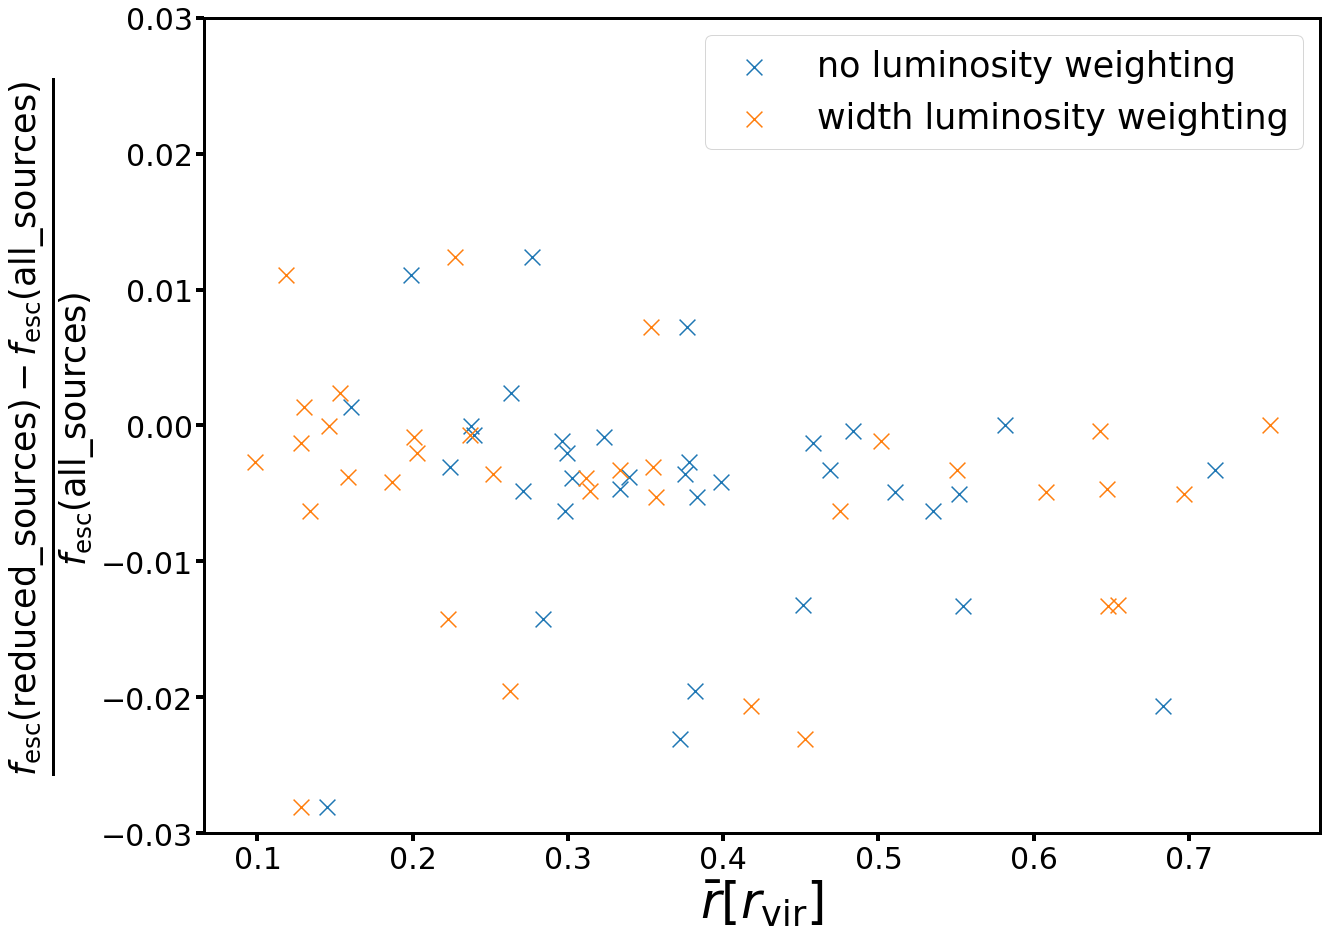

In [161]:
x_values = df_merge['MeanDistances']
x_values2 = df_merge['MeanDistanceLum']
y_values = (df_merge['f_esc_esc_sources']-df_merge['f_esc_all_sources'])/df_merge['f_esc_all_sources']
plt.scatter(x_values, y_values, s=250, marker='x', label='no luminosity weighting')
plt.scatter(x_values2, y_values, s=250, marker='x', label='width luminosity weighting')
x_label = r'$\bar{r}[r_\mathrm{vir}]$'
y_label = r'$\frac{f_\mathrm{esc}(\mathrm{reduced\_sources})-f_\mathrm{esc}(\mathrm{all\_sources})}{f_\mathrm{esc}(\mathrm{all\_sources})}$'
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.xlabel(x_label, fontsize=50)
plt.ylabel(y_label, fontsize=50)
plt.rc('axes', linewidth=3)
plt.tick_params(length=8, width=4)
plt.tick_params(length=4, width=2, which='minor')
plt.legend(fontsize=35)
plt.ylim(-0.03,0.03)
#plt.yscale('log')
plt.rcParams["figure.figsize"] = (20, 15);

No handles with labels found to put in legend.


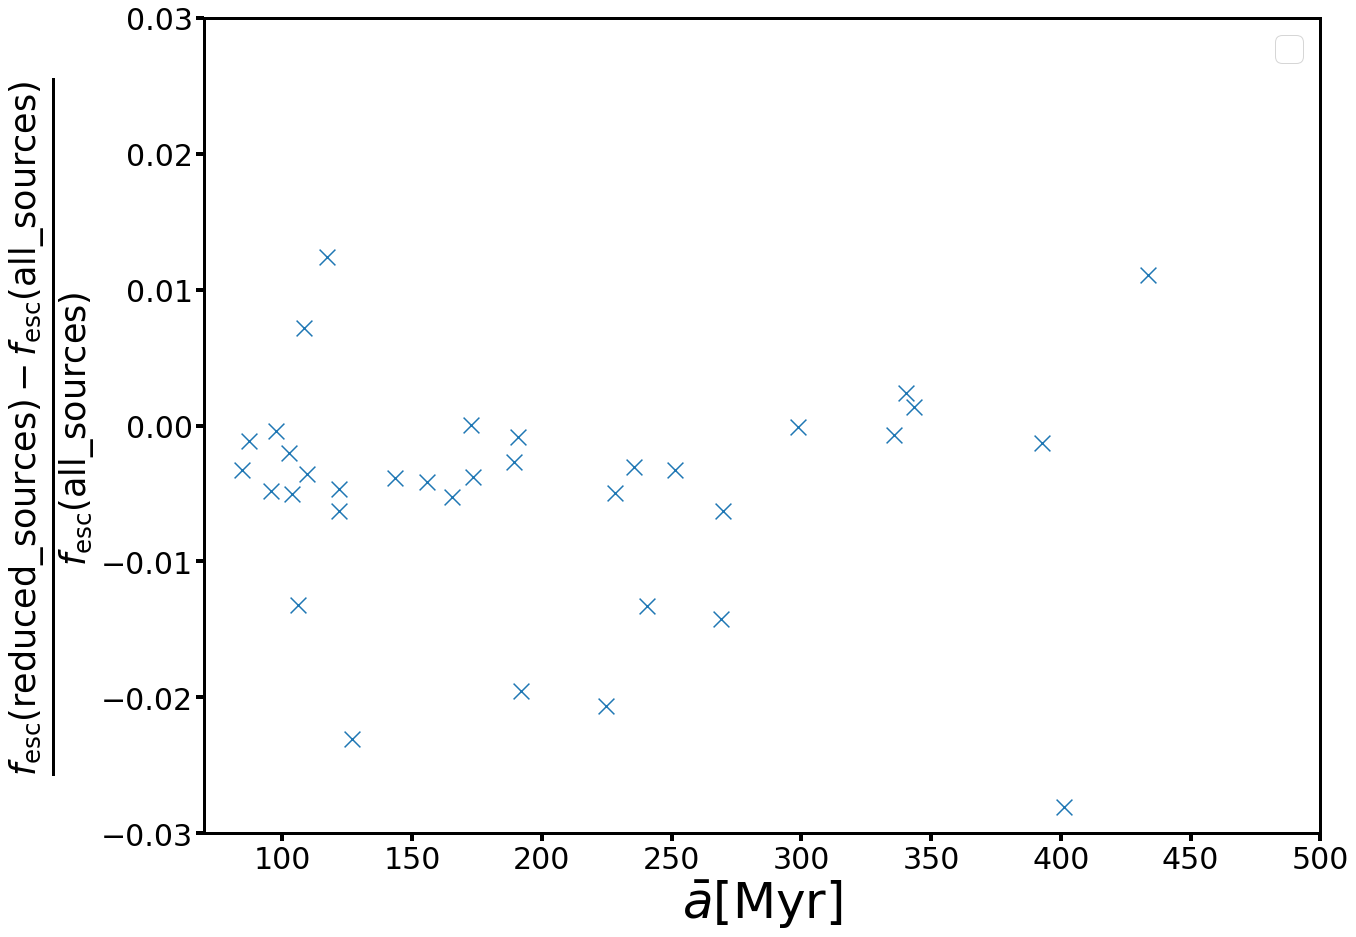

In [191]:
x_values = df_merge['MeanAges']
y_values = (df_merge['f_esc_esc_sources']-df_merge['f_esc_all_sources'])/df_merge['f_esc_all_sources']
plt.scatter(x_values, y_values, s=250, marker='x')
x_label = r'$\bar{a}[\mathrm{Myr}]$'
y_label = r'$\frac{f_\mathrm{esc}(\mathrm{reduced\_sources})-f_\mathrm{esc}(\mathrm{all\_sources})}{f_\mathrm{esc}(\mathrm{all\_sources})}$'
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.xlabel(x_label, fontsize=50)
plt.ylabel(y_label, fontsize=50)
plt.rc('axes', linewidth=3)
plt.tick_params(length=8, width=4)
plt.tick_params(length=4, width=2, which='minor')
plt.legend(fontsize=35)
plt.ylim(-0.03,0.03)
#plt.xscale('log')
plt.xlim(7e1,5e2)
#plt.yscale('log')
plt.rcParams["figure.figsize"] = (20, 15);

No handles with labels found to put in legend.


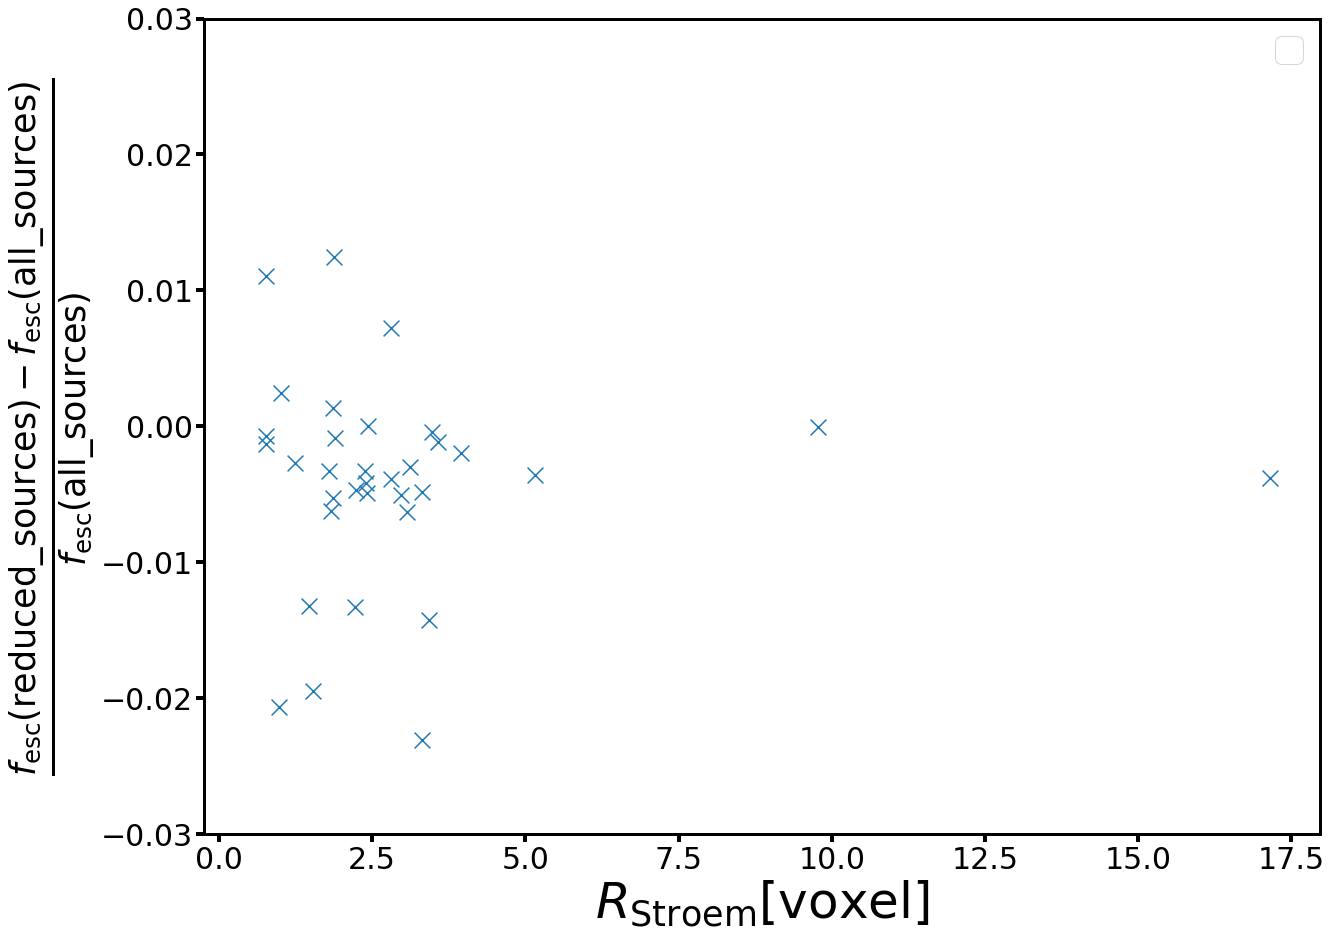

In [195]:
x_values = df_merge['FarMeanStroemgren']
y_values = (df_merge['f_esc_esc_sources']-df_merge['f_esc_all_sources'])/df_merge['f_esc_all_sources']
plt.scatter(x_values, y_values, s=250, marker='x')
x_label = r'$R_\mathrm{Stroem}[\mathrm{voxel}]$'
y_label = r'$\frac{f_\mathrm{esc}(\mathrm{reduced\_sources})-f_\mathrm{esc}(\mathrm{all\_sources})}{f_\mathrm{esc}(\mathrm{all\_sources})}$'
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.xlabel(x_label, fontsize=50)
plt.ylabel(y_label, fontsize=50)
plt.rc('axes', linewidth=3)
plt.tick_params(length=8, width=4)
plt.tick_params(length=4, width=2, which='minor')
plt.legend(fontsize=35)
plt.ylim(-0.03,0.03)
#plt.xscale('log')
#plt.xlim(7e1,5e2)
#plt.yscale('log')
plt.rcParams["figure.figsize"] = (20, 15);

No handles with labels found to put in legend.


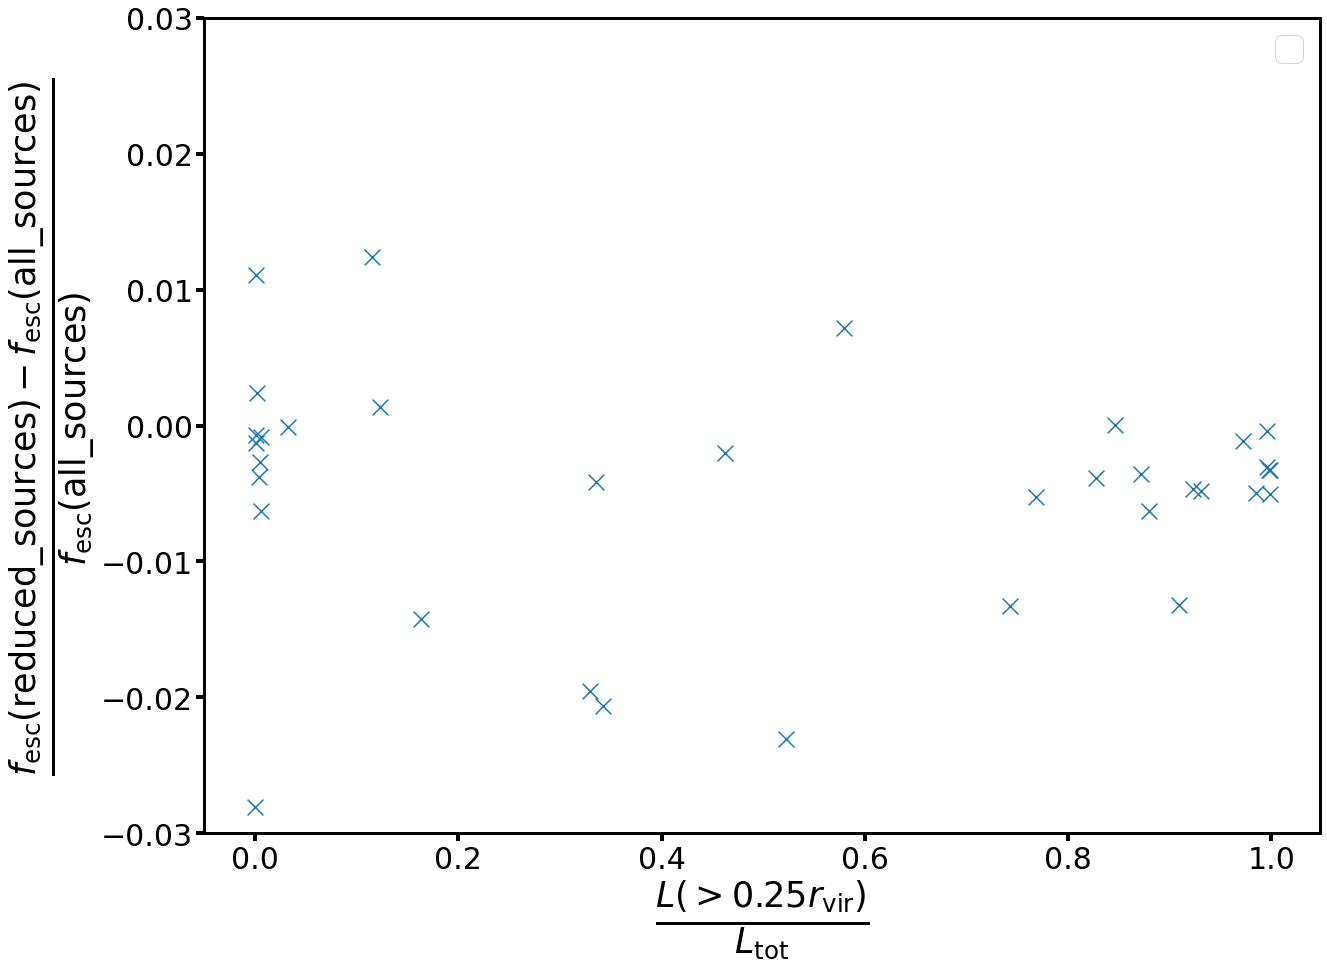

In [238]:
x_values = df_merge['FarLum']
y_values = (df_merge['f_esc_esc_sources']-df_merge['f_esc_all_sources'])/df_merge['f_esc_all_sources']
plt.scatter(x_values, y_values, s=250, marker='x')
x_label = r'$\frac{L(>0.25r_\mathrm{vir})}{L_\mathrm{tot}}$'
y_label = r'$\frac{f_\mathrm{esc}(\mathrm{reduced\_sources})-f_\mathrm{esc}(\mathrm{all\_sources})}{f_\mathrm{esc}(\mathrm{all\_sources})}$'
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.xlabel(x_label, fontsize=50)
plt.ylabel(y_label, fontsize=50)
plt.rc('axes', linewidth=3)
plt.tick_params(length=8, width=4)
plt.tick_params(length=4, width=2, which='minor')
plt.legend(fontsize=35)
plt.ylim(-0.03,0.03)
#plt.xscale('log')
#plt.xlim(1e-4,1.3)
#plt.yscale('log')
plt.rcParams["figure.figsize"] = (20, 15);

In [603]:
test_path = '/ptmp/mpa/mglatzle/TNG_f_esc/all_sources/run/L35n2160TNG/sn008/sel_halos_df.pickle'
sim = Sim(test_path)

KeyError: 'gridsize'

In [121]:
radii = [5]
all_stroemgren = []
cell_size, density_maps = get_density_maps(4238, 6, 'all_sources')
column_names=['x', 'y', 'z', 'a', 'Q', 'b', 'name', 'c', 'halo', 'd', 'packets', 'e', 'loc_uv', 'f', 'loc_x']
halo_path = f'/ptmp/mpa/mglatzle/TNG_f_esc/all_sources/input/L35n2160TNG/sn013/g4238'
source_name = 'sources_ic00.in'
sources_path = os.path.join(halo_path, source_name)
sources = pd.read_table(sources_path, delimiter='\t', names=column_names)
print(cell_size)
initial_lum = sources['Q'].str.replace('d','e').astype('float')
lum = np.array(initial_lum) 
coordinates = np.array([sources.x, sources.y, sources.z])
coord = coordinates.T
for radius in radii:
    stroemgren = []
    for i in range(len(lum)):
        densities = density_maps['H']
        temperatures = density_maps['T']
        source_pos = coord[i]
        luminosity=lum[i]*1e52
        density, temperature = average_quantities(source_pos, radius, densities, temperatures)
        print(density, temperature)
        stroem_rad = stroemgren_rad(density, temperature, luminosity)/cell_size
        stroemgren.append(stroem_rad)
    all_stroemgren.append(stroemgren)

/freya/ptmp/mpa/mglatzle/TNG_f_esc/all_sources/run/L35n2160TNG/sn013/g4238
8.18202634287168e+20
0.056970038 6427.6675
0.06003123 7242.518
0.062543415 6881.9795
0.04487876 6655.204
0.05651149 7323.175
0.039473183 10360.734
0.07056644 7439.937
0.051502608 8773.398
0.066251636 7428.1626
0.04091623 12672.006
0.0403819 10692.775
0.05620093 7609.2246
0.056192566 7419.1724
0.024781398 12291.34
0.010269059 26884.861
0.007838862 21339.055
0.05053481 10053.949
0.0023209325 40421.906
0.0018138898 115436.336
0.0017518719 51611.777
0.03955253 17080.713


In [118]:
cell_size

8.18202634287168e+20

In [115]:
print(np.max(all_stroemgren[1]))

11.09649493512286


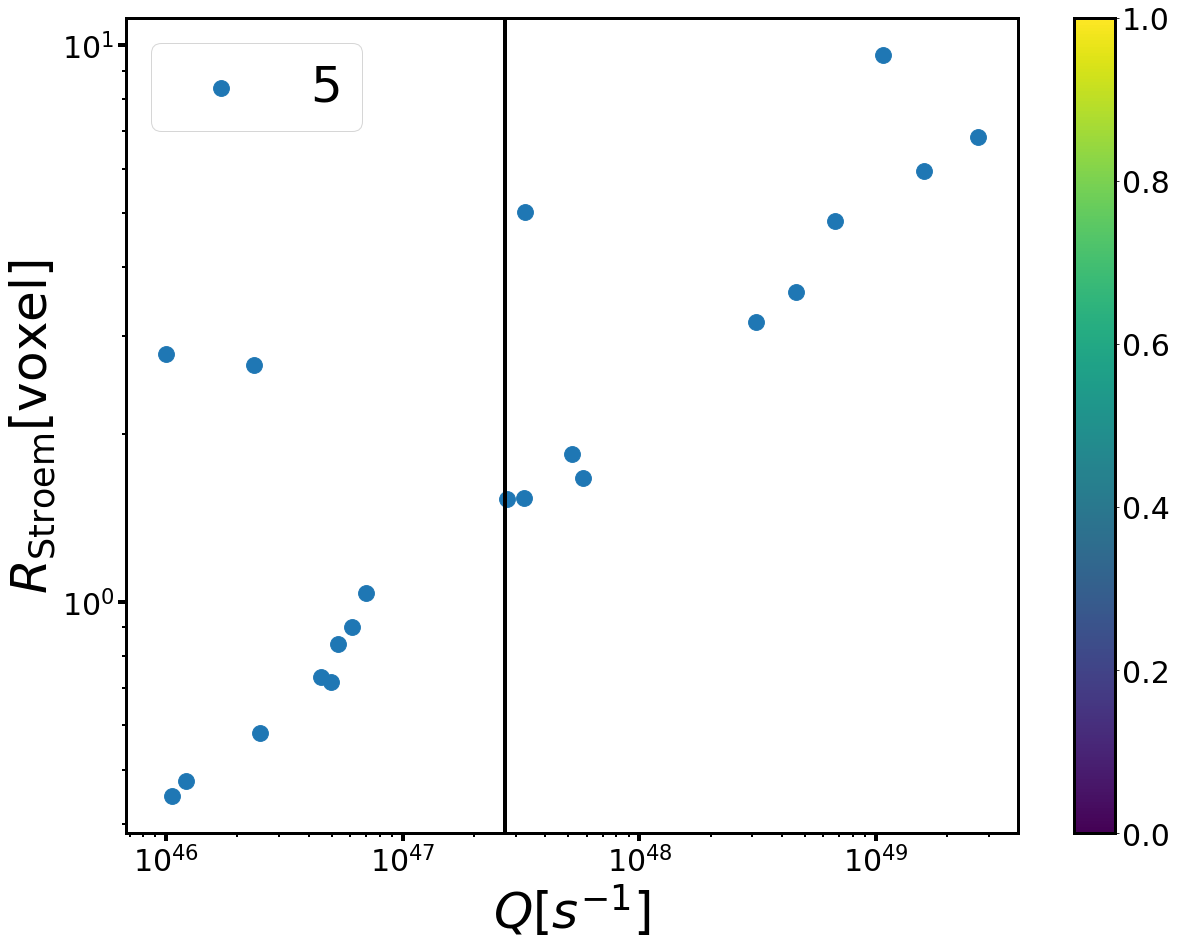

In [113]:
markers = ['+', 'x', 'o', '^']
plt.scatter(lum*1e52, all_stroemgren[2], s=250, marker=markers[2], label=radii[1])#, c=distances)
plt.axvline(x=np.max(lum)*1e50, linewidth=4, color='black', linestyle='-')
plt.xscale('log')
plt.yscale('log')
x_label = r'$Q[s^{-1}]$'
y_label = r'$R_\mathrm{Stroem}$[voxel]'
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.xlabel(x_label, fontsize=50)
plt.ylabel(y_label, fontsize=50)
plt.rc('axes', linewidth=3)
plt.tick_params(length=8, width=4)
plt.tick_params(length=4, width=2, which='minor')
plt.legend(fontsize=50)
plt.colorbar()
#plt.ylim(0.1,100)
#plt.yscale('log')
plt.rcParams["figure.figsize"] = (20, 15);

In [86]:
lum, stroem = all_stroemgren_rad('all_sources')

No handles with labels found to put in legend.


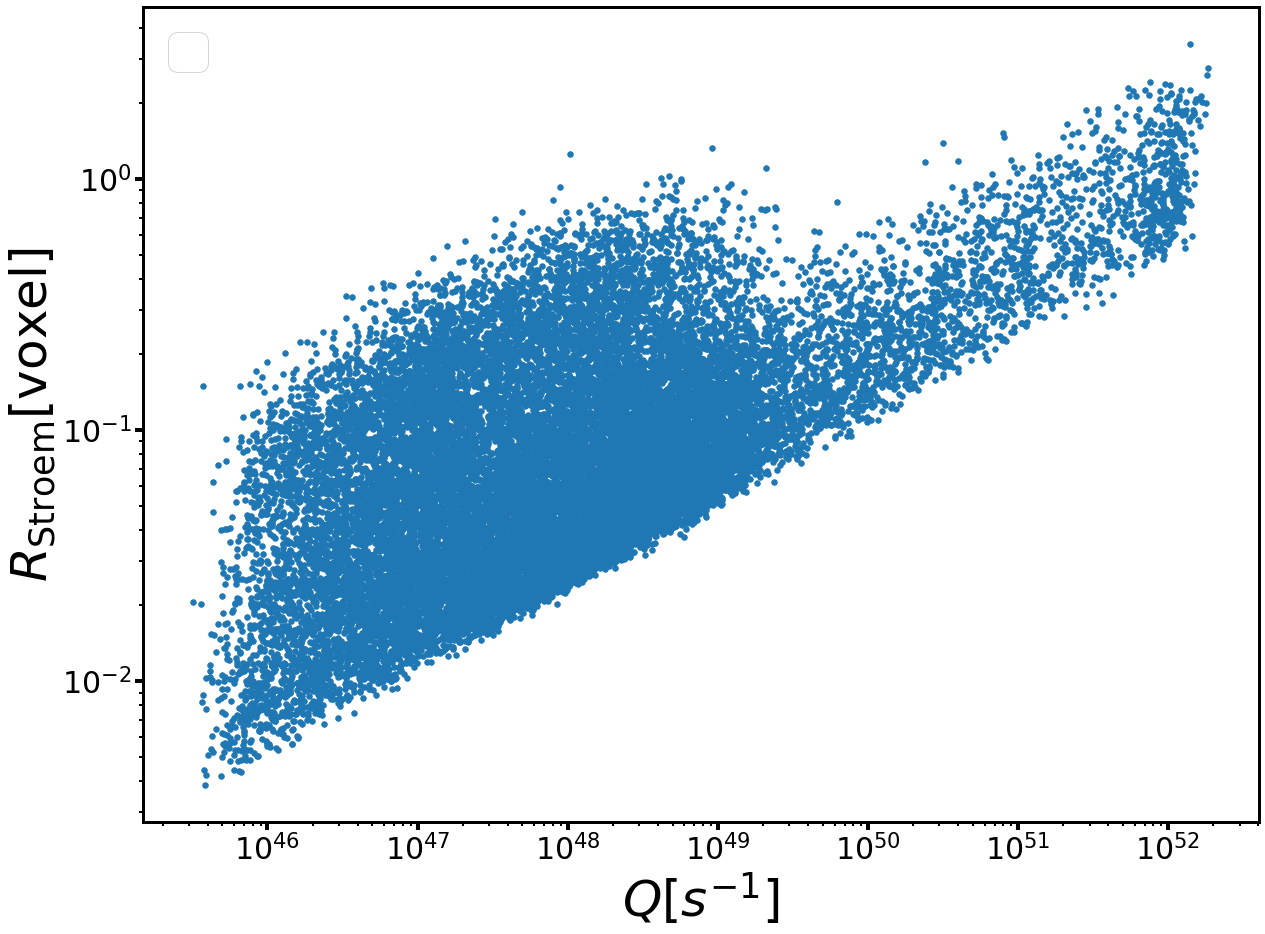

In [89]:
markers = ['+', 'x', 'o', '^']
#for i, stroem in enumerate(all_stroemgren):
plt.scatter(np.array(lum)*1e52, stroem, s=30, marker=markers[2])
#plt.axvline(x=np.max(lum)*1e50, linewidth=4, color='black', linestyle='-')
plt.xscale('log')
plt.yscale('log')
x_label = r'$Q[s^{-1}]$'
y_label = r'$R_\mathrm{Stroem}$[voxel]'
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.xlabel(x_label, fontsize=50)
plt.ylabel(y_label, fontsize=50)
plt.rc('axes', linewidth=3)
plt.tick_params(length=8, width=4)
plt.tick_params(length=4, width=2, which='minor')
plt.legend(fontsize=50)
#plt.ylim(0.1,100)
#plt.yscale('log')
plt.rcParams["figure.figsize"] = (20, 15);